In [1]:
## IMPORT NECESSARY LIBRARIES
import pandas as pd
import os
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import *
from sklearn.multiclass import *
from sklearn.svm import *
import warnings


source=os.getcwd()
print(source)

videoVecDat_uid = pd.DataFrame()
df = pd.DataFrame()
list_=[]

## IMPORT INPUT DATA
files = glob.glob(source+"/CORPUS_*.TXT")
for file in files:
    print(file)
    df_pre = pd.read_csv(file, delimiter = "\t",names=["id", "title", "abstract"],encoding='ISO-8859-1')
    list_.append(df_pre)
df = pd.concat(list_)

print(df.shape)
df = df.dropna(subset=['abstract'])
## LOOK AT SAMPLE DATA
print(df.shape)
print(df.head(n=1))
df_test = df.head(n=1)
print(df_test[:1].abstract.tolist()[0])
text=df_test[:1].abstract.tolist()[0]

C:\Users\owner\Downloads\udacCourses\predAnalytics\Clustering
C:\Users\owner\Downloads\udacCourses\predAnalytics\Clustering\CORPUS_ONE.txt
C:\Users\owner\Downloads\udacCourses\predAnalytics\Clustering\CORPUS_TWO.txt
(1680, 3)
(1674, 3)
   id                                              title  \
0   1  Dust-Ion-Acoustic Solitary waves in a Magnetiz...   

                                            abstract  
0  The nonlinear dust-ion acoustic (DIA) solitary...  
The nonlinear dust-ion acoustic (DIA) solitary structures have been studied in a dusty plasma including of the Cairns-Gurevich distribution for electrons, both negative and positive ions and immobile opposite polarity dust grains. The external magnetic field directed along the z-axis is considered. By using the standard reductive perturbation technique and the hydrodynamics model for the ion fluid, the modified Zakharov-Kuznetsov equation was derived for small but finite amplitude waves and was given the solitary wave solution 

In [2]:
## NLP PRE-PROCESSING USING NLTK

#text="Chhota Bheem - Happy Diwali | Diwali Special Video"
def nltk_clean_sent(line):
    if len(line)>0:
        ## remove the punctuation/html tags/multispaces with single from the line
        line_lower = line.strip()
        line_emots = re.sub(r'[\u200b-\u2fff]+',' ',line_lower)
        #line_digis = re.sub(r'[0-9]+',' ',line_emots)
        line_spaces = re.sub(r'[\s]+',' ',line_emots)
        line_punct = re.sub(r'<.*?>',' ',line_spaces)
        line_punct1 = re.sub(r'\(.*?\)',' ',line_punct)
        line_punct2 = re.sub('['+string.punctuation+']',' ',line_punct1)
        line = line_punct2
    return line


def nltk_apply_lemma(line):
    tokens_lemmas = [WordNetLemmatizer().lemmatize(word) for word in line.split()]
    ## stemming
    tokens_stops = [word for word in tokens_lemmas if word not in stopwords.words('english')]
    tokens_stops = [word.lower() for word in tokens_stops if len(word.strip())>2]
    tokens_stops = list(set(tokens_stops))
    return tokens_stops

def nltk_extract_tags(line):
        ## tokenize the sentence/get tokens that contains only letters
        line_clean = nltk_clean_sent(line)
        #print(line_clean)
        ## apply lemmatize/stemming and remove stopwords
        #token_lemma = nltk_apply_lemma(line_clean)
        #return list(set(token_lemma))
        return line_clean

nltk_extract_tags(text)

'The nonlinear dust ion acoustic   solitary structures have been studied in a dusty plasma including of the Cairns Gurevich distribution for electrons  both negative and positive ions and immobile opposite polarity dust grains  The external magnetic field directed along the z axis is considered  By using the standard reductive perturbation technique and the hydrodynamics model for the ion fluid  the modified Zakharov Kuznetsov equation was derived for small but finite amplitude waves and was given the solitary wave solution for the parameters relevant  Using the appropriate the independent variable  we could find the modified Korteweg de Vries equation  By plotting some figures  we have discussed and emphasized that how the different plasma values such as the trapping parameter  the nonthermal electron parameter and the ion cyclotron frequency can influence on the solitary wave structures  Also  by means of the bifurcation theory of planar dynamical systems  we have extracted the cente

16


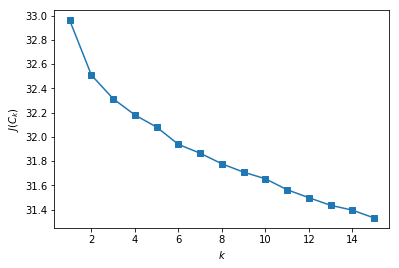

In [3]:
## FEATURE ENGINEERING USING TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=nltk_extract_tags,min_df=2,max_df=0.95,stop_words='english',use_idf=True,ngram_range=(1,2));
vec = tfidf_vectorizer.fit(df['abstract']);   # train vec using data
vectorized = vec.transform(df['abstract']);   # transform data using vec

## CHOOSE OPTIMAL NO OF CLUSTERS
maxVal = int(len(df)/100)
print(maxVal)
inertia = []
for k in range(1, maxVal):
    kmeans = KMeans(n_clusters=k, init='k-means++',max_iter=10,random_state=0).fit(vectorized)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, maxVal), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [4]:
## MODEL FIT USING K-MEANS
## no of clusters might change depend on the data that we feed in and 
## can take a call what number to chose based on the elbow method
num_clusters = 4 # FROM ABOVE ELBOW METHOD GRAPH

km = KMeans(n_clusters=num_clusters,init='k-means++',max_iter=10,random_state=0).fit(vectorized)
clusters = km.labels_.tolist()
df["label"]=clusters
print(df.head(n=2))
#print(clusters)

## CLEAN AND NORMALIZE TEST DATA
df_test = pd.read_csv(source+"/TEST_CORPUS.TXT", delimiter = "\t",names=["id", "title", "abstract"],encoding='ISO-8859-1')
print(df_test.shape)
df_test = df_test.dropna(subset=['abstract'])
print(df_test.shape)
print(df_test.head(n=1))

## PREDICTION TEST DATA USING UNSUPERVISED
list2Vec = vec.transform(df_test["abstract"])  # transform test data using vec
km.predict(list2Vec)

   id                                              title  \
0   1  Dust-Ion-Acoustic Solitary waves in a Magnetiz...   
1   2  Acoustic absorption of solid foams with thin m...   

                                            abstract  label  
0  The nonlinear dust-ion acoustic (DIA) solitary...      1  
1  We measured the acoustic absorption, on the 0....      2  
(28, 3)
(28, 3)
   id                                       title  \
0   1  Subsonic Potentials in Ultra dense Plasmas   

                                            abstract  
0  The existence of the subsonic dynamic potentia...  


array([1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1,
       0, 2, 1, 0, 2, 1])

In [5]:
# CLUSTERING IS A KIND OF UNSUPERVISED MODEL.FROM THE ABOVE PREDICTION WE CAN'T EVALUATE THE MODEL AS WE DONT HAVE TARGET LABELS. 
# THE ONLY PARAMETER TUNING CAN BE DONE HERE IS CHOSING THE NO OF CLUSTERS and MAX_ITERATIONS THATS HOW WE CAN CHANGE THE BEHAVIOUR OF DATA.
# THE OTHER APPROACH CAN BE USED IS SUPERVISED APPROACH WHEN WE HAVE THE LABELLED DATA.PLEASE SEE FORM THE NEXT SECTION.

In [6]:
## SUPERVISED APPROACH - CONSIDERED WE HAVE A LABELLED DATA SET (we have considered the clustered labels as targets) 
## - TRAIN/TEST THE MODEL
warnings.filterwarnings("ignore")
from sklearn.metrics import *
from sklearn.ensemble import *

def perform(classifiers, vectorizers, train_data, test_data):
    for classifier in classifiers:
        print("classifier name =",classifier)
        for vectorizer in vectorizers:
            string = ''
            string += classifier.__class__.__name__ + ' with ' + vectorizer.__class__.__name__

            # train
            vectorize_text = vectorizer.fit_transform(train_data.abstract)
            classifier.fit(vectorize_text, train_data.label)

            # score
            vectorize_text1 = vectorizer.transform(test_data.abstract)
            score = classifier.score(vectorize_text1, test_data.label)
            #string += '. Has score: ' + str(score) 
            #print(string)
            print("Train Accuracy:", accuracy_score(train_data.label, classifier.predict(vectorize_text)))
            print("Test Accuracy:", accuracy_score(test_data.label,classifier.predict(vectorize_text1)))
#             print("Confusion Matrix:", confusion_matrix(test_data.label, classifier.predict(vectorize_text1)))

split = int(len(df)-len(df)/5) ## split 20% among train/test
train = df[:split]
test = df[split:]

perform(
    [
        #OneVsRestClassifier(SVC(kernel='linear',C=10,gamma=0.01)),
        OneVsRestClassifier(SGDClassifier(alpha=0.0001)),
        OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 0.8,random_state = 0))
    ],
    [
        tfidf_vectorizer
    ],
    train,
    test
)

classifier name = OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1)
Train Accuracy: 0.9873039581777446
Test Accuracy: 0.9014925373134328
classifier name = OneVsRestClassifier(estimator=LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)
Train Accuracy: 0.9447348767737117
Test Accuracy: 0.9074626865671642


In [7]:
## FROM THE ABOVE ACCURACY METRICS WE CAN OBSERVE THERE IS A SLIGHT OVERFITTING HAPPENED FROM BOTH THE MODELS
## PREFERABLE I CAN GO WITH LOGISTIC regression that has little imrovememt on prone to overfitting compare to SGD CLASSIFIER model.
## BY HAVING MORE TRAINING DATA  and do some parameter tuning on C WE CAN FURTHUR REDUCE OVERFITTING

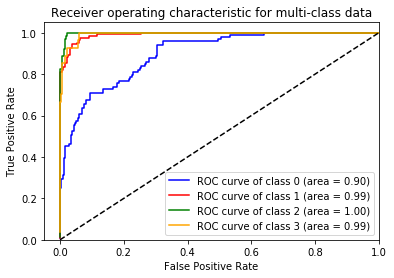

In [8]:
## LOOK UP AUC SCORE FOR EACH OF THE TARGET CLASSES SO WE CAN WORK UPON THE CLASSES THAT ARE NOT PERFORMING WELL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

X = df.abstract
y = df.label

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2,3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)


vectorize_train = tfidf_vectorizer.fit_transform(X_train)
vectorize_text = tfidf_vectorizer.transform(X_test)
#classifier = OneVsRestClassifier(SVC(kernel='linear',C=10,gamma=0.01,random_state=0,probability=True))
classifier = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 0.8,random_state = 0))
y_score = classifier.fit(vectorize_train, y_train).decision_function(vectorize_text)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#colors = cycle(['blue', 'red', 'green'])
colors = ['blue', 'red', 'green','orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [9]:
## AS WE CAN SEE THE DATA LOOKS PRONE TO OVERFITTING BECAUSE WE CONSIDERED ONLY LESS SAMPLES OF DATA.
## ON OVERALL LOGISTIC REGRESSION WITH L2 REGULARIZATION WORKS WELL WITH THIS DATA BECAUSE LOGISTIC GOOD AT REDUCING OVERFITTING.
## ROC PROVIDES THE EVALUATION METRICS OF MULTICLASS CLASSIFICATION PROBLEM. FROM THE GRAPH WE CAN OBSERVE THAT ALL CLASSES PREDICTED
## WELL BUT STILL IMPROVEMENT CAN BE DONE ON CLASS 0 LABEL.
## WE CAN CONCENTRATE ON ADDING MORE DATA AND ALSO WORKS ON IMPROVING THE AUC SCORE OF CLASS 0 TARGET.

In [10]:
# km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, precompute_distances=True, verbose=0, random_state=None, cpy_x=True, n_jobs=1)